# Imports

In [1]:
import zipfile
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import re
import torch
from torch.utils.data import DataLoader
import random
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Utils

In [2]:
# Clean the plate
def clean_plate(text):
    return re.sub(r'[^A-Z0-9]', '', text.upper())

def encode(text):
    return [char_to_idx[c] for c in text if c in char_to_idx]

def decode(indices):
    return ''.join(idx_to_char[i] for i in indices if i != 0)  # ignora il blank


In [3]:
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)

    targets = [torch.tensor(encode(label), dtype=torch.long) for label in labels]
    targets_concat = torch.cat(targets)
    target_lengths = torch.tensor([len(t) for t in targets], dtype=torch.long)

    input_lengths = torch.full(size=(len(images),), fill_value=35, dtype=torch.long)

    return images, targets_concat, input_lengths, target_lengths


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
def greedy_decode(output, idx_to_char):
    output = output.permute(1, 0, 2)  # [B, T, C]
    decoded = []

    for probs in output:
        pred = torch.argmax(probs, dim=1).tolist()  # [T]
        prev = -1
        seq = []
        for p in pred:
            if p != prev and p != 0:
                seq.append(idx_to_char[p])
            prev = p
        decoded.append("".join(seq))

    return decoded

def compute_accuracy(preds, targets):
  correct_chars = total_chars = correct_plates = 0
  for p, t in zip(preds, targets):
      total_chars += max(len(p), len(t))
      correct_chars += sum(a == b for a, b in zip(p, t))
      if p == t:
          correct_plates += 1
  cer = correct_chars / total_chars
  plate_acc = correct_plates / len(targets)
  return cer, plate_acc

In [6]:
def evaluate_on_loader(model, dataloader, idx_to_char, device):
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels, input_lengths, label_lengths in tqdm(dataloader, desc="Evaluating"):

            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            outputs = model(images)  # [T, B, C]
            preds = greedy_decode(outputs, idx_to_char)

            # Ricostruisci i target reali
            targets = []
            start = 0
            for length in label_lengths:
                label_seq = labels[start:start + length]
                text = ''.join([idx_to_char[i.item()] for i in label_seq])
                targets.append(text)
                start += length

            for pred, true in zip(preds, targets):
                all_preds.append(pred)
                all_targets.append(true)
                total += 1
                if pred == true:
                    correct += 1

    acc = correct / total * 100
    return all_preds, all_targets

In [7]:
def show_wrong_predictions(model, test_loader, idx_to_char, device, max_errors=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, labels, input_lengths, label_lengths in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = greedy_decode(outputs, idx_to_char)

            targets = []
            start = 0
            for length in label_lengths:
                length = int(length)
                label_seq = labels[start:start+length]
                text = ''.join([idx_to_char[i.item()] for i in label_seq])
                targets.append(text)
                start += length

            for img, pred, true in zip(images, preds, targets):
                if pred != true:
                    img_np = img.cpu().numpy().transpose(1, 2, 0)  # da [C,H,W] a [H,W,C]
                    img_np = (img_np * 0.5 + 0.5).clip(0, 1)       # denormalize (mean=0.5, std=0.5)

                    plt.figure(figsize=(6, 2))
                    plt.imshow(img_np)
                    plt.title(f"Pred: {pred} | GT: {true}", fontsize=12)
                    plt.axis('off')
                    plt.show()

                    shown += 1
                    if shown >= max_errors:
                        return

In [27]:
def show_three_correct_predictions(model, test_loader, idx_to_char, device):
    model.eval()
    correct_samples = []

    with torch.no_grad():
        for images, labels, input_lengths, label_lengths in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = greedy_decode(outputs, idx_to_char)

            targets = []
            start = 0
            for length in label_lengths:
                length = int(length)
                label_seq = labels[start:start + length]
                text = ''.join([idx_to_char[i.item()] for i in label_seq])
                targets.append(text)
                start += length

            for img, pred, true in zip(images, preds, targets):
                if pred == true:
                    img_np = img.cpu().numpy().transpose(1, 2, 0)
                    img_np = (img_np * 0.5 + 0.5).clip(0, 1)
                    correct_samples.append((img_np, pred))

                    if len(correct_samples) >= 3:
                        break
            if len(correct_samples) >= 3:
                break

    # Seleziona 3 a caso
    selected = random.sample(correct_samples, 3)

    # Mostra in una riga
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    for ax, (img_np, pred) in zip(axs, selected):
        ax.imshow(img_np)
        ax.set_title(f"{pred}", fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Dataset preparation

In [8]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
zip_path = '/content/drive/MyDrive/Dataset_CV/RECOGNITION/UC3-LM_recognition.zip'
extract_dir = '/content/UC3-LM'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [10]:
# Definizione del vocabolario
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
vocab = sorted(set(alphabet))

idx_to_char = ['-'] + vocab
char_to_idx = {char: idx for idx, char in enumerate(idx_to_char)}  # 0 = blank
num_classes = len(idx_to_char)



In [11]:
class UC3LMDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.filenames = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]
        self.transform = transform or transforms.Compose([
            transforms.Resize((48, 144)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.img_dir, fname)
        label_path = os.path.join(self.label_dir, fname.split('.')[0] + '.txt')

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        with open(label_path, 'r', encoding='utf-8') as f:
            label = clean_plate(f.read().strip())

        return image, label

In [12]:
#Transformations for data augmentation
train_transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=4, translate=(0.02, 0.02), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])


transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

In [13]:
base_path = '/content/UC3-LM/filtered_OCR_clean'

train_dataset = UC3LMDataset(
    img_dir=os.path.join(base_path, 'images/train'),
    label_dir=os.path.join(base_path, 'labels/train'),
    transform=train_transform         # ⬅️ qui lo applichi
)


val_dataset = UC3LMDataset(
    img_dir=os.path.join(base_path, 'images/val'),
    label_dir=os.path.join(base_path, 'labels/val'),
    transform=transform
)

test_dataset = UC3LMDataset(
    img_dir=os.path.join(base_path, 'images/test'),
    label_dir=os.path.join(base_path, 'labels/test'),
    transform=transform
)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Network

In [16]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_classes):
        super(CRNN, self).__init__()

        # INPUT: [B, 3, 48, 144]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # RGB input
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 64, 24, 72]

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 128, 12, 36]

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 1), padding=(0, 1)),  # [B, 256, 6, 37]

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 1), padding=(0, 1))   # [B, 512, 3, 38]
        )

        self.rnn = nn.GRU(input_size=512 * 3, hidden_size=128,
                  num_layers=1, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128 * 2, num_classes)


    def forward(self, x):
        conv = self.cnn(x)            # [B, 512, 3, 38]
        b, c, h, w = conv.size()
        conv = conv.permute(3, 0, 1, 2)   # [T=38, B, C, H=3]
        conv = conv.reshape(w, b, c * h) # [T=38, B, 512*3]

        rnn_out, _ = self.rnn(conv)      # [T, B, 512]
        rnn_out = self.dropout(rnn_out)
        output = self.fc(rnn_out)        # [T, B, num_classes]
        return F.log_softmax(output, dim=2)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CRNN(img_height=48, num_classes=num_classes).to(device)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=7e-5, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)


cuda


# Train (Fine-tuning with checkpoints)

In [ ]:
# Checkpoint paths
checkpoint_dir = "/content/drive/MyDrive/Computer_vision/crnn_finetune_weights_uc3lm"
os.makedirs(checkpoint_dir, exist_ok=True)
last_ckpt_path = os.path.join(checkpoint_dir, "last.pth")
best_ckpt_path = os.path.join(checkpoint_dir, "best.pth")

# Load pre-trainined weights (without fc layer because different vocabulary)
state_dict = torch.load("/content/drive/MyDrive/Computer_vision/crnn_weights/best_crnn.pth", map_location=device)
filtered_dict = {k: v for k, v in state_dict.items() if not k.startswith("fc.")}
model.load_state_dict(filtered_dict, strict=False)
print("Pre-trained weights loaded and FC ignored")


if os.path.exists(last_ckpt_path):
    checkpoint = torch.load(last_ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint.get('scheduler_state_dict'):
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Restart from checkpoint (epoch {start_epoch})")
else:
    start_epoch = 0
    print("No checkpoint found. Start from epoch 0")

def train_finetune(model, train_loader, val_loader, epochs, device, optimizer, criterion, scheduler=None, seed=42):
    set_seed(seed)
    best_val_loss = float('inf')

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"[FT] Epoch {epoch+1}/{epochs}")

        for images, labels, input_lengths, label_lengths in pbar:

            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            outputs = model(images)  # [T, B, C]
            T, B = outputs.size(0), outputs.size(1)
            input_lengths = torch.full(size=(B,), fill_value=T, dtype=torch.long, device=device)

            loss = criterion(outputs, labels, input_lengths, label_lengths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(train_loss=total_loss / (pbar.n + 1), lr=optimizer.param_groups[0]['lr'])

        val_loss = evaluate_finetune(model, val_loader, criterion, device)
        print(f"\n[FT] Epoch {epoch+1} - Val Loss: {val_loss:.4f}")

        if scheduler:
            scheduler.step(val_loss)

        #Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'best_val_loss': best_val_loss
        }, last_ckpt_path)

        #Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_ckpt_path)
            print("Best model saved")

def evaluate_finetune(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, labels, input_lengths, label_lengths in val_loader:

            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            outputs = model(images)  # [T, B, C]
            T, B = outputs.size(0), outputs.size(1)
            input_lengths = torch.full(size=(B,), fill_value=T, dtype=torch.long, device=device)

            loss = criterion(outputs, labels, input_lengths, label_lengths)
            total_loss += loss.item()

            preds = greedy_decode(outputs, idx_to_char)
            targets = []
            start = 0
            for length in label_lengths:
                label_seq = labels[start:start+length]
                text = ''.join([idx_to_char[i.item()] for i in label_seq])
                targets.append(text)
                start += length

            print("Pred:", preds[:3])
            print("True:", targets[:3])
            break

    return total_loss / len(val_loader)

Pre-trained weights loaded and FC ignored
No checkpoint found. Start from epoch 0


In [ ]:
train_finetune(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    seed=42
)

[FT] Epoch 1/20: 100%|██████████| 127/127 [00:09<00:00, 12.81it/s, lr=7e-5, train_loss=4.76]


Pred: ['', '', '']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 1 - Val Loss: 0.1681
Best model saved


[FT] Epoch 2/20: 100%|██████████| 127/127 [00:08<00:00, 14.37it/s, lr=7e-5, train_loss=3.25]


Pred: ['', '', '']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 2 - Val Loss: 0.1529
Best model saved


[FT] Epoch 3/20: 100%|██████████| 127/127 [00:08<00:00, 14.23it/s, lr=7e-5, train_loss=2.78]


Pred: ['', '', '2']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 3 - Val Loss: 0.1074
Best model saved


[FT] Epoch 4/20: 100%|██████████| 127/127 [00:07<00:00, 16.19it/s, lr=7e-5, train_loss=1.86]


Pred: ['771', '912', '828B']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 4 - Val Loss: 0.0711
Best model saved


[FT] Epoch 5/20: 100%|██████████| 127/127 [00:08<00:00, 14.79it/s, lr=7e-5, train_loss=1.53]


Pred: ['771M', '912B', '828B']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 5 - Val Loss: 0.0622
Best model saved


[FT] Epoch 6/20: 100%|██████████| 127/127 [00:09<00:00, 13.92it/s, lr=7e-5, train_loss=1.37]


Pred: ['771M', '912B', '828B']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 6 - Val Loss: 0.0565
Best model saved


[FT] Epoch 7/20: 100%|██████████| 127/127 [00:07<00:00, 15.90it/s, lr=7e-5, train_loss=1.24]


Pred: ['771M', '912B', '828B']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 7 - Val Loss: 0.0525
Best model saved


[FT] Epoch 8/20: 100%|██████████| 127/127 [00:08<00:00, 14.34it/s, lr=7e-5, train_loss=1.15]


Pred: ['771M', '912B', '828B']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 8 - Val Loss: 0.0507
Best model saved


[FT] Epoch 9/20: 100%|██████████| 127/127 [00:09<00:00, 13.91it/s, lr=7e-5, train_loss=1.04]


Pred: ['771M', '912B', '828B']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 9 - Val Loss: 0.0458
Best model saved


[FT] Epoch 10/20: 100%|██████████| 127/127 [00:07<00:00, 15.99it/s, lr=7e-5, train_loss=0.92]


Pred: ['771M', '912B', '828T']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 10 - Val Loss: 0.0308
Best model saved


[FT] Epoch 11/20: 100%|██████████| 127/127 [00:08<00:00, 14.36it/s, lr=7e-5, train_loss=0.508]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 11 - Val Loss: 0.0110
Best model saved


[FT] Epoch 12/20: 100%|██████████| 127/127 [00:09<00:00, 13.66it/s, lr=7e-5, train_loss=0.266]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 12 - Val Loss: 0.0080
Best model saved


[FT] Epoch 13/20: 100%|██████████| 127/127 [00:08<00:00, 14.55it/s, lr=7e-5, train_loss=0.194]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 13 - Val Loss: 0.0049
Best model saved


[FT] Epoch 14/20: 100%|██████████| 127/127 [00:08<00:00, 14.61it/s, lr=7e-5, train_loss=0.153]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 14 - Val Loss: 0.0034
Best model saved


[FT] Epoch 15/20: 100%|██████████| 127/127 [00:09<00:00, 13.75it/s, lr=7e-5, train_loss=0.136]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 15 - Val Loss: 0.0034
Best model saved


[FT] Epoch 16/20: 100%|██████████| 127/127 [00:09<00:00, 13.53it/s, lr=7e-5, train_loss=0.111]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 16 - Val Loss: 0.0022
Best model saved


[FT] Epoch 17/20: 100%|██████████| 127/127 [00:08<00:00, 15.51it/s, lr=7e-5, train_loss=0.1]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 17 - Val Loss: 0.0023


[FT] Epoch 18/20: 100%|██████████| 127/127 [00:09<00:00, 14.01it/s, lr=7e-5, train_loss=0.0818]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 18 - Val Loss: 0.0016
Best model saved


[FT] Epoch 19/20: 100%|██████████| 127/127 [00:09<00:00, 13.55it/s, lr=7e-5, train_loss=0.0758]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 19 - Val Loss: 0.0020


[FT] Epoch 20/20: 100%|██████████| 127/127 [00:08<00:00, 15.85it/s, lr=7e-5, train_loss=0.0729]


Pred: ['771DM', '912FB', '828TB']
True: ['771DM', '912FB', '828TB']

[FT] Epoch 20 - Val Loss: 0.0017


# Test

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(img_height=48, num_classes=num_classes)
model.load_state_dict(torch.load(
    "/content/drive/MyDrive/Computer_vision/crnn_finetune_weights_uc3m-lp/best.pth",
    map_location=device))
model.eval().to(device)

# Valutazione
all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)

print(f"\nTest UC3-LM")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:  {plate_acc:.4f}")

# Mostra gli errori
print("\nPrediction errors:")
for i, (pred, true) in enumerate(zip(all_preds, all_targets)):
    if pred != true:
        print(f"[{i}] GT: {true}  -->  Pred: {pred}")


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Test UC3-LM
Character accuracy: 0.9663
Sequence accuracy:  0.9250

Prediction errors:
[18] GT: 858KS  -->  Pred: 858K5
[20] GT: 714SY  -->  Pred: 7145Y
[36] GT: 439JN  -->  Pred: GT
[57] GT: 220DP  -->  Pred: 220DB
[66] GT: M075V  -->  Pred: 4075V
[95] GT: 853CZ  -->  Pred: 453Z
[107] GT: 051FN  -->  Pred: 051FV
[113] GT: 355PZ  -->  Pred: 355PT
[117] GT: 422ND  -->  Pred: 22XV
[126] GT: M847L  -->  Pred: M4817
[150] GT: 530FF  -->  Pred: 30FF
[158] GT: 028TC  -->  Pred: 028TG


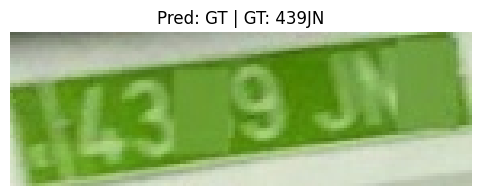

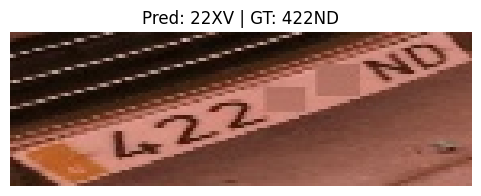

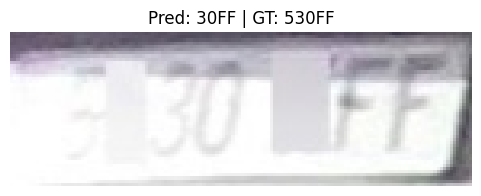

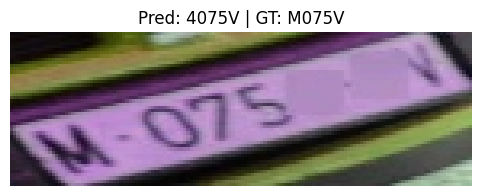

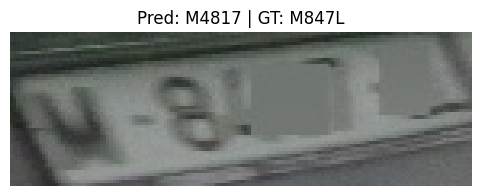

In [ ]:
show_wrong_predictions(model, test_loader, idx_to_char, device, max_errors=5)

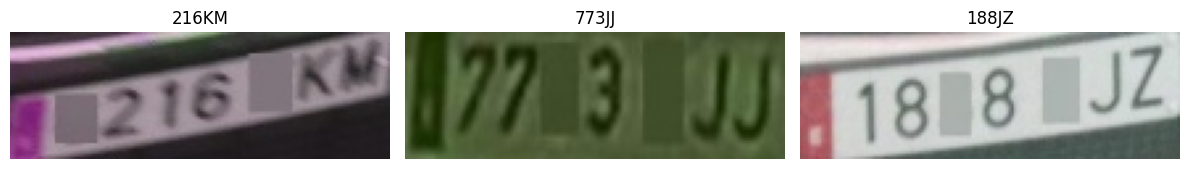

In [29]:
show_three_correct_predictions(model, test_loader, idx_to_char, device)